In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler, StandardScaler
from tensorflow import keras

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC

In [3]:
df_train = pd.read_csv('fraudTrain.csv')
df_train.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


Proportion of the classes in the data:
0    0.994211
1    0.005789
Name: is_fraud, dtype: float64


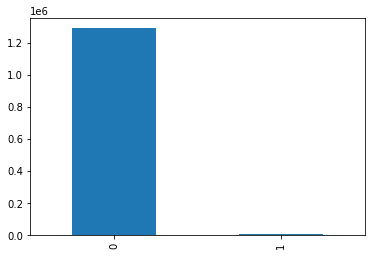

In [3]:
# Assessing the balance of the class label (fraud vs no fraud).
df_train['is_fraud'].value_counts().plot.bar()
print('Proportion of the classes in the data:')
print(df_train['is_fraud'].value_counts() / len(df_train))

In [4]:
df_train['is_fraud'].value_counts()

# The target variable is imbalanced

0    1289169
1       7506
Name: is_fraud, dtype: int64

In [3]:
# Checking for missing values
df_train.isnull().sum()

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64

- Thus, there are no missing values

In [5]:
df_train.nunique()

Unnamed: 0               1296675
trans_date_trans_time    1274791
cc_num                       983
merchant                     693
category                      14
amt                        52928
first                        352
last                         481
gender                         2
street                       983
city                         894
state                         51
zip                          970
lat                          968
long                         969
city_pop                     879
job                          494
dob                          968
trans_num                1296675
unix_time                1274823
merch_lat                1247805
merch_long               1275745
is_fraud                       2
dtype: int64

In [6]:
# Investigating whether there is multicollinearity in the dataset - that requires cleaning. 
corr = df_train.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

<ipython-input-6-e2f88459ea3c>:3: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient(cmap='coolwarm').set_precision(2)


,Unnamed: 0,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,is_fraud
Unnamed: 0,1.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,-0.00,-0.00
cc_num,0.00,1.00,0.00,0.04,-0.06,-0.05,-0.01,0.00,-0.06,-0.05,-0.00
amt,-0.00,0.00,1.00,0.00,-0.00,-0.00,0.01,-0.00,-0.00,-0.00,0.22
zip,0.00,0.04,0.00,1.00,-0.11,-0.91,0.08,0.00,-0.11,-0.91,-0.00
lat,0.00,-0.06,-0.00,-0.11,1.00,-0.02,-0.16,0.00,0.99,-0.02,0.00
long,-0.00,-0.05,-0.00,-0.91,-0.02,1.00,-0.05,-0.00,-0.02,1.00,0.00
city_pop,-0.00,-0.01,0.01,0.08,-0.16,-0.05,1.00,-0.00,-0.15,-0.05,0.00
unix_time,1.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,1.00,0.00,-0.00,-0.01
merch_lat,0.00,-0.06,-0.00,-0.11,0.99,-0.02,-0.15,0.00,1.00,-0.02,0.00
merch_long,-0.00,-0.05,-0.00,-0.91,-0.02,1.00,-0.05,-0.00,-0.02,1.00,0.00


In [4]:
# Dropping columns
df_train = df_train.drop(columns=['Unnamed: 0'])
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
# Dropping columns
df_train = df_train.drop(columns=['merch_long', 'merch_lat'])
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,is_fraud
0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,Moravian Falls,NC,28654,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,0
1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,Orient,WA,99160,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,0
2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,Malad City,ID,83252,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0
3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,Boulder,MT,59632,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,0
4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,Doe Hill,VA,24433,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 20 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   trans_date_trans_time  1296675 non-null  object 
 1   cc_num                 1296675 non-null  int64  
 2   merchant               1296675 non-null  object 
 3   category               1296675 non-null  object 
 4   amt                    1296675 non-null  float64
 5   first                  1296675 non-null  object 
 6   last                   1296675 non-null  object 
 7   gender                 1296675 non-null  object 
 8   street                 1296675 non-null  object 
 9   city                   1296675 non-null  object 
 10  state                  1296675 non-null  object 
 11  zip                    1296675 non-null  int64  
 12  lat                    1296675 non-null  float64
 13  long                   1296675 non-null  float64
 14  city_pop          

In [19]:
from sklearn.base import BaseEstimator, TransformerMixin

class SafeLabelEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.encoder = LabelEncoder()
    
    def fit(self, X, y=None):
        self.encoder.fit(X)
        self.classes_ = self.encoder.classes_
        return self
    
    def transform(self, X):
        X_encoded = X.apply(lambda x: x if x in self.classes_ else 'other')
        return self.encoder.transform(X_encoded)

In [20]:
categorical_features = ["merchant", "category", "city", "job"]  
encoder = SafeLabelEncoder()
for col in categorical_features:
    df_train[col] = encoder.fit_transform(df_train[col])

In [21]:
df_train.head()

,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,city,state,zip,lat,long,city_pop,job,dob,trans_num,unix_time,is_fraud
0,2019-01-01 00:00:18,2703186189652095,514,8,4.97,Jennifer,Banks,F,561 Perry Cove,526,NC,28654,36.0788,-81.1781,3495,370,1988-03-09,0b242abb623afc578575680df30655b9,1325376018,0
1,2019-01-01 00:00:44,630423337322,241,4,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,612,WA,99160,48.8878,-118.2105,149,428,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,0
2,2019-01-01 00:00:51,38859492057661,390,0,220.11,Edward,Sanchez,M,594 White Dale Suite 530,468,ID,83252,42.1808,-112.2620,4154,307,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,0
3,2019-01-01 00:01:16,3534093764340240,360,2,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,84,MT,59632,46.2306,-112.1138,1939,328,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,0
4,2019-01-01 00:03:06,375534208663984,297,9,41.96,Tyler,Garcia,M,408 Bradley Rest,216,VA,24433,38.4207,-79.4629,99,116,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,0


In [22]:
df = df_train.drop(columns=["trans_date_trans_time", 'first', 'last', 'gender', 'street','dob','trans_num', 'unix_time'])
df.head()

,cc_num,merchant,category,amt,city,state,zip,lat,long,city_pop,job,is_fraud
0,2703186189652095,514,8,4.97,526,NC,28654,36.0788,-81.1781,3495,370,0
1,630423337322,241,4,107.23,612,WA,99160,48.8878,-118.2105,149,428,0
2,38859492057661,390,0,220.11,468,ID,83252,42.1808,-112.2620,4154,307,0
3,3534093764340240,360,2,45.00,84,MT,59632,46.2306,-112.1138,1939,328,0
4,375534208663984,297,9,41.96,216,VA,24433,38.4207,-79.4629,99,116,0


In [23]:
X_train = df[['cc_num', 'merchant', 'category', 'amt', 'city', 'zip', 'lat', 'long','job']]  
y_train = df["is_fraud"]

In [25]:
print(X_train.dtypes)

cc_num      float64
merchant    float64
category    float64
amt         float64
city        float64
zip         float64
lat         float64
long        float64
job         float64
dtype: object


In [24]:
X_train['cc_num'] = X_train['cc_num'].astype(float)  
X_train['merchant'] = X_train['merchant'].astype(float)
X_train['category'] = X_train['category'].astype(float)
X_train['city'] = X_train['city'].astype(float)
X_train['zip'] = X_train['zip'].astype(float)
X_train['job'] = X_train['job'].astype(float)

<ipython-input-24-ef2131ac4d98>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['cc_num'] = X_train['cc_num'].astype(float)
<ipython-input-24-ef2131ac4d98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['merchant'] = X_train['merchant'].astype(float)
<ipython-input-24-ef2131ac4d98>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [26]:
# Standardize input features for training
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [27]:
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification

In [28]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# Train the model
model.fit(X_train_scaled, y_train, epochs=20, batch_size=200)

Epoch 1/20
6484/6484 [==============================] - 9s 1ms/step - loss: 0.0110 - accuracy: 0.9967
Epoch 2/20
6484/6484 [==============================] - 10s 1ms/step - loss: 0.0109 - accuracy: 0.9967
Epoch 3/20
6484/6484 [==============================] - 9s 1ms/step - loss: 0.0108 - accuracy: 0.9967
Epoch 4/20
6484/6484 [==============================] - 10s 2ms/step - loss: 0.0107 - accuracy: 0.9968
Epoch 5/20
6484/6484 [==============================] - 10s 2ms/step - loss: 0.0107 - accuracy: 0.9967
Epoch 6/20
6484/6484 [==============================] - 10s 2ms/step - loss: 0.0105 - accuracy: 0.9968
Epoch 7/20
6484/6484 [==============================] - 10s 2ms/step - loss: 0.0105 - accuracy: 0.9968
Epoch 8/20
6484/6484 [==============================] - 9s 1ms/step - loss: 0.0105 - accuracy: 0.9969
Epoch 9/20
6484/6484 [==============================] - 10s 2ms/step - loss: 0.0104 - accuracy: 0.9968
Epoch 10/20
6484/6484 [==============================] - 10s 1ms/step - loss

In [31]:
# Load test data
df_test = pd.read_csv("fraudTest.csv")

In [34]:
print(df_test.dtypes)

Unnamed: 0                 int64
trans_date_trans_time     object
cc_num                     int64
merchant                  object
category                  object
amt                      float64
first                     object
last                      object
gender                    object
street                    object
city                      object
state                     object
zip                        int64
lat                      float64
long                     float64
city_pop                   int64
job                       object
dob                       object
trans_num                 object
unix_time                  int64
merch_lat                float64
merch_long               float64
is_fraud                   int64
dtype: object


In [35]:
X_test = df_test[['cc_num', 'merchant', 'category', 'amt', 'city', 'zip', 'lat', 'long', 'job']]
y_test = df_test["is_fraud"]

In [ ]:
# Define features and target variable for testing
X_test = df_test[['cc_num', 'merchant', 'category', 'amt', 'city', 'zip', 'lat', 'long', 'job']]
y_test = df_test["is_fraud"]

In [23]:
# Standardize input features for testing
X_test_scaled = scaler.transform(X_test)

ValueError: could not convert string to float: 'fraud_Kirlin and Sons'

In [ ]:
# Predict classes for test data
y_pred = model.predict_classes(X_test_scaled)

In [ ]:
# Evaluate the model on test data
y_pred_prob = model.predict(X_test_scaled)
y_pred = (y_pred_prob > 0.5).astype(int)

In [ ]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC AUC Score:", roc_auc)

In [ ]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()